In [0]:
import re
import json
import collections
import numpy as np
import pickle


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions    
        

In [0]:
captions = readTextFile("/content/drive/My Drive/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

In [0]:
captions = captions.split("\n")[:-1]

In [6]:
captions[0].split('\t')

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [7]:
print(len(captions))

40460


In [0]:
#dictionary to map each image to list of caption it has


descriptions = {}


for x in captions:
        first,second = x.split("\t")
        img_name =  first.split(".")[0]
        #if image_id is already present or not
        if descriptions.get(img_name) is None:
            descriptions[img_name] = []
        descriptions[img_name].append(second)     

In [9]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

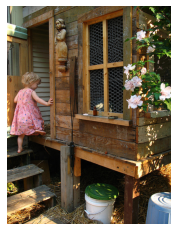

In [15]:
IMG_PATH = "/content/drive/My Drive/Flickr_Data/Images/1000268201_693b08cb0e.jpg"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(img)
plt.show()

In [0]:
#data cleaning

In [0]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence  = " ".join(sentence)
    return sentence

In [17]:
clean_text("A cat is sitting over the house number 64")

'cat is sitting over the house number'

In [0]:
#clean all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [19]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [0]:
#write data to a text file
f = open("descriptions.txt","w")
f.write(str(descriptions))
f.close()


In [0]:
#vocabulary -- set of all unique words model can predict
descriptions = None
with open("descriptions.txt","r") as f:
    descriptions = f.read()
json_acceptable_string = descriptions.replace("'","\"")    
descriptions = json.loads(json_acceptable_string)    

In [22]:
type(descriptions)

dict

In [23]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [0]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

In [25]:
print(len(vocab))

8424


In [26]:
#total no of words across all sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print(len(total_words))    

373837


In [27]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [28]:
#filter words from the vocab to ceratin threshold frequency it handel duplicates words
counter = collections.Counter(total_words)
freq_count = dict(counter)
print(len(freq_count.keys()))

8424


In [0]:
#sort this dict acc to freq
sorted_freq_cnt = sorted(freq_count.items(),reverse = True,key = lambda x:x[1])


#filtering

threshold = 10
sorted_freq_cnt = [ x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [30]:
len(total_words)

1845

In [0]:
#preapare data
train_file_data = readTextFile("/content/drive/My Drive/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/My Drive/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")


In [32]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

print(train[:5])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']


In [0]:
#prepare descriptions for trainig data
#add a start and end token in our training data
train_descriptions  = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [34]:
train_descriptions["2513260012_03d33305cf"]

['startseq black dog is running after white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through low lying body of water endseq']

In [35]:
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.optimizers import Adam
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras import utils


Using TensorFlow backend.


In [36]:
model = ResNet50(weights = "imagenet",input_shape = (224,224,3))
model.summary()

102858752/102853048 [==============================] - 9s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [0]:
model_new = Model(model.input,model.layers[-2].output)

In [0]:
def pre_process_img(img):
    img = image.load_img(img,target_size = (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis =0)
    #noramlisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


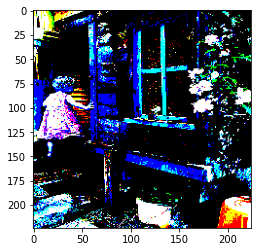

In [39]:
img = pre_process_img("/content/drive/My Drive/Flickr_Data/Images/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.show()

In [0]:
def encode_img(img):
    img = pre_process_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector
    

In [42]:
encode_img("/content/drive/My Drive/Flickr_Data/Images/1000268201_693b08cb0e.jpg")

array([0.04154297, 0.17076068, 0.2927861 , ..., 0.05089626, 0.3132238 ,
       0.86007506], dtype=float32)

In [43]:
encoding_train = {}

#imgaeid-->feature_vector
for ix,img_id in enumerate(train):
    img_path = "/content/drive/My Drive/Flickr_Data/Images/"+img_id+".jpg"
    
    encoding_train[img_id] = encode_img(img_path)
    
    if(ix%100==0):
        print(ix)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900


In [0]:
#store everything to the disk
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [45]:
encoding_test = {}
#imgaeid-->feature_vector
for ix,img_id in enumerate(test):
    img_path = "/content/drive/My Drive/Flickr_Data/Images/"+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    if(ix%100==0):
        print(ix)

0
100
200
300
400
500
600
700
800
900


In [0]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [47]:
#data preprocessing for captions
len(total_words)

1845

In [0]:
word2idx ={}
idx2word={}
for i,word in enumerate(total_words):
    word2idx[word] = i+1
    idx2word[i+1] = word

In [49]:
word2idx["dog"]
idx2word[1]

'in'

In [0]:
#two special words
idx2word[1846] = "stratseq"
word2idx["startseq"] = 1846
idx2word[1847] = "endseq"
word2idx["endseq"] = 1847

In [51]:
vocab_size = len(word2idx)+1
print(vocab_size)

1848


In [0]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))

In [53]:
max_len

35

In [0]:
from keras.utils import to_categorical


In [0]:
#data loader
def data_generator(train_descriptions,encoding_train,word2idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word2idx[word] for word in desc.split() if word in word2idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [0]:
f = open("/content/drive/My Drive/glove.6B.50d.txt",encoding = "utf8")

In [0]:
##word embeddings
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype = "float")
    embedding_index[word] = word_embedding


In [0]:
f.close()

In [59]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [0]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word2idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx]  =embedding_vector
    return matrix

In [61]:
embedding_mat  = get_embedding_matrix()
embedding_mat.shape

(1848, 50)

In [0]:
#model architecture

In [0]:
input_imgs_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_imgs_features)
inp_img2 = Dense(256,activation="relu")(inp_img1)

In [0]:
#captions as input
input_captions = Input(shape=(max_len,))
inp_cap1 =Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [0]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation="relu")(decoder1)
outputs = Dense(vocab_size,activation="softmax")(decoder2)


#combined model
model = Model(inputs = [input_imgs_features,input_captions],outputs = outputs)

In [65]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
model.layers[2].set_weights([embedding_mat])
model.layers[2].trainable  =False

In [0]:
model.compile(loss = "categorical_crossentropy",optimizer = "adam")

In [0]:
#training of model

In [0]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [0]:
def train_model():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word2idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_weights'+str(i)+'.h5')

In [0]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word2idx[w] for w in in_text.split() if w in word2idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx2word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [73]:
train_model()

Epoch 1/1
2000/2000 [==============================] - 304s 152ms/step - loss: 4.2987
Epoch 1/1
2000/2000 [==============================] - 301s 150ms/step - loss: 3.5811
Epoch 1/1
2000/2000 [==============================] - 300s 150ms/step - loss: 3.3204
Epoch 1/1
2000/2000 [==============================] - 309s 154ms/step - loss: 3.1651
Epoch 1/1
2000/2000 [==============================] - 307s 153ms/step - loss: 3.0513
Epoch 1/1
2000/2000 [==============================] - 304s 152ms/step - loss: 2.9643
Epoch 1/1
2000/2000 [==============================] - 304s 152ms/step - loss: 2.8983
Epoch 1/1
2000/2000 [==============================] - 306s 153ms/step - loss: 2.8445
Epoch 1/1
2000/2000 [==============================] - 310s 155ms/step - loss: 2.7963
Epoch 1/1
2000/2000 [==============================] - 309s 155ms/step - loss: 2.7557
Epoch 1/1
 781/2000 [==========>...................] - ETA: 3:09 - loss: 2.7255

KeyboardInterrupt: ignored

In [0]:
from keras.models import load_model
model = load_model('/content/model_weights9.h5')

KeyError: '2513260012_03d33305cf.jpg'

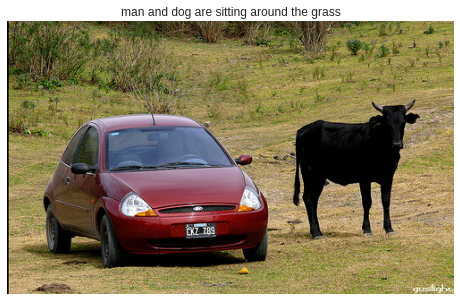

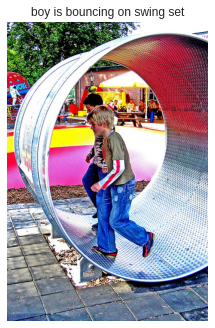

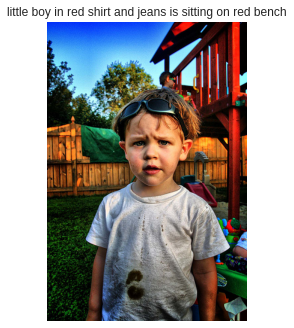

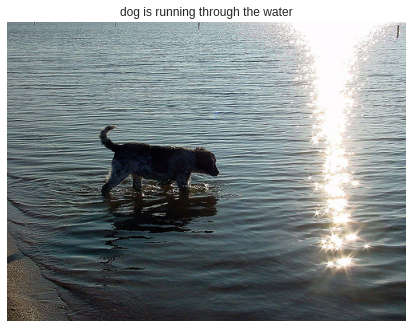

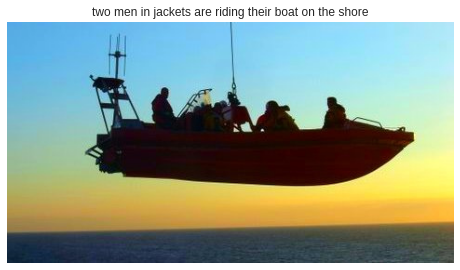

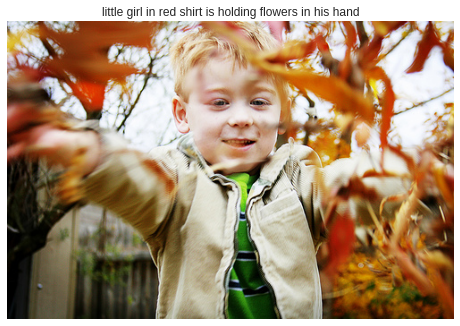

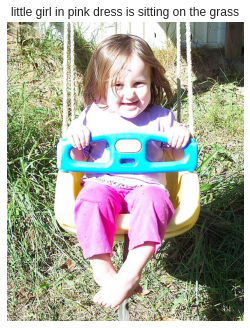

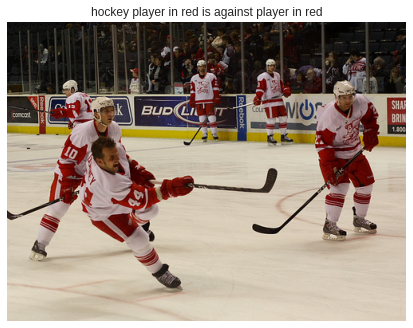

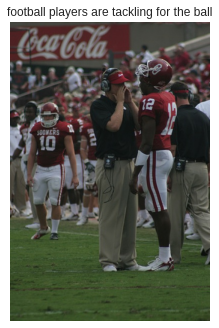

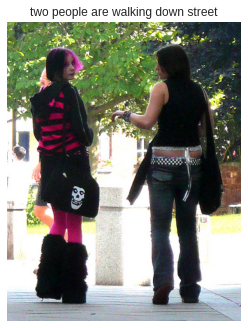

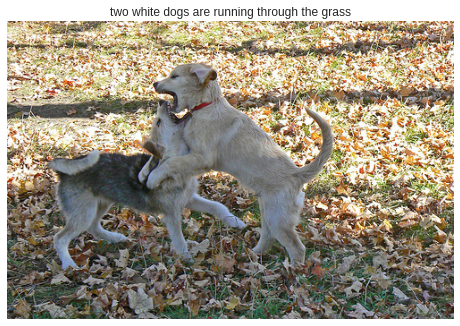

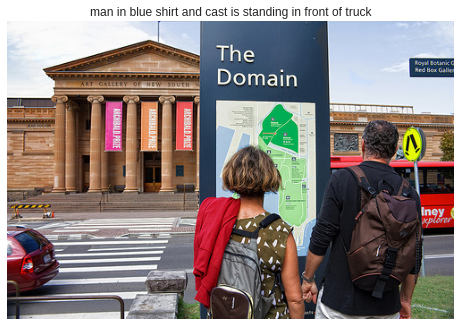

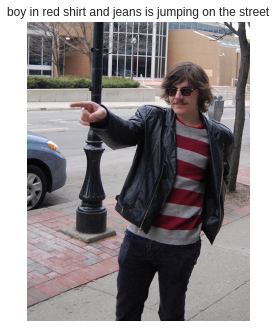

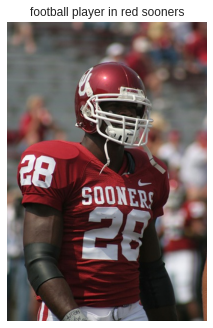

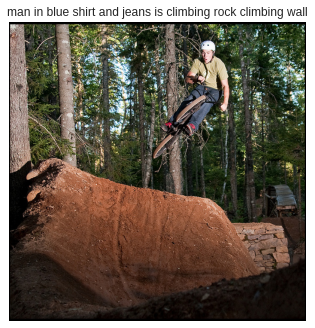

In [85]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/content/drive/My Drive/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

In [79]:
print(caption)